In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib import pyplot
import os
import pickle
import random
from random import shuffle
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import cv2
from scipy import fft

In def image_preprocessing(image):

cv2.fastNlMeansDenoisingColored parameters are:

- src : Input 8-bit 3-channel image.
- dst : Output image with the same size and type as src .
- h : Parameter regulating filter strength for luminance component. Bigger h value perfectly removes noise but also removes image details, smaller h value preserves details but also preserves some noise.
- templateWindowSize : Size in pixels of the template patch that is used to compute weights. Should be odd. Recommended value 7 pixels
- searchWindowSize : Size in pixels of the window that is used to compute weighted average for given pixel. Should be odd. Affect performance linearly: greater searchWindowsSize - greater denoising time. Recommended value 21 pixels

In [3]:
def image_preprocessing(image):
    
    # Image size for our model.
    MODEL_INPUT_IMAGE_SIZE = [ 96 , 96 ]

    # Resizing
    image = tf.image.resize(image, MODEL_INPUT_IMAGE_SIZE)
    
    # Denosing used in Audience dataset only
    image = cv2.fastNlMeansDenoisingColored(np.uint8(image),None,5,10,7,21)
    
    # Normalization
    image = image/255
    
    return image # Return image after resizing

# > **Audience Dataset**

Statistics and info
- Total number of photos: 26,580
- #Downloaded Images = 19370
- Total number of subjects: 2,284
- Number of age groups / labels: 8 (0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-)
- Gender labels: Yes
- In the wild: Yes
- Subject labels: Yes

Data Fields
- images: tensor containing the image
- ages: tensor containing ages (label) of an corresponding image
- gender: tensor containing gender of each image
- x: part of bounding box of the face in the original Flickr image
- y: part of bounding box of the face in the original Flickr image
- dx: part of bounding box of the face in the original Flickr image
- dy: part of bounding box of the face in the original Flickr image
- tilt_ang: pose of the face in the original Flickr image
- fiducial_yaw_angle: pose of the face in the original Flickr image
- fiducial_score: score of the landmark detector

> **Loading Audience Dataset**

In [ ]:
def install_deeplake():
    
    !pip3 install deeplake

In [ ]:
def download_audience_dataset():
    
    import deeplake
    audience_dataset_path = 'hub://activeloop/adience'
    audience_ds = deeplake.load(audience_dataset_path) # Returns a Deep Lake Dataset but does not download data locally
    
    return audience_ds

> **Audience Dataset Visualization**

In [ ]:
def audience_visualization(audience_ds):
    
    audience_ds.visualize()

In [ ]:
def audience_summary(audience_ds):
    
    print("Size of the Audience Dataset = ", audience_ds.tensors['ages'].numpy().size, '\n')
    print("dict_keys(['images', 'labels']) : ", audience_ds.tensors.keys(), '\n')  
    
    print("Genders: ", audience_ds.genders.info, '\n')
    print(np.unique(audience_ds.genders.numpy()), '\n')

    print("Ages: ", audience_ds.ages.info, '\n') # Should have 8 (0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-) but it has 30 classes because of the missing ages between each 2 classes
    print(np.unique(audience_ds.ages.numpy()), '\n')
    
    audience_ds.summary()

> **Adding Audience dataset to the whole dataset with resizing it**

In [ ]:
def get_random_age_from_its_class(index):
    age_index = {0: random.randint(25, 32),
           1: random.randint(38, 43),
           2: random.randint(4, 6),
           3: random.randint(60, 100),
           4: random.randint(15, 20),
           5: random.randint(48, 53), 
           6: random.randint(8, 12),
           7: random.randint(0, 2),
           8: random.randint(0, 100),
           9: random.randint(38, 48),
           10: 35,
           11: 3,
           12: 55,
           13: 58,
           14: 22,
           15: 13,
           16: 45,
           17: 36,
           18: 23,
           19: random.randint(38, 42),
           20: random.randint(8, 23),
           21: random.randint(27, 32),
           22: 57,
           23: 56,
           24: 2,
           25: 29,
           26: 34,
           27: 42,
           28: 46,
           29: 32}
    # Normalization
    return age_index[index]/100

In [ ]:
def add_audience_dataset_to_our_dataset(audience_ds):
    
    dataset = np.array([])
    
    for i in range(audience_ds.images.shape[0]): # audience_ds.images.shape[0] = 19370
        
        if i%500 == 0:
            print(i)
            
        image = image_preprocessing(audience_ds.images[i])
        
        age_index = audience_ds.ages[i].numpy()[0]
        age = get_random_age_from_its_class(age_index)
        
        if i==0:
            dataset = np.array([[image, age], ])
        else:
            dataset = np.append(dataset, [[image, age]], axis=0)
            
    return dataset

In [ ]:
def Preparing_Audience_Dataset():
    
    # Installing
    install_deeplake()
    audience_ds = download_audience_dataset()
    
    # # Visualization
    # audience_visualization(audience_ds)
    # audience_summary(audience_ds)
    
    # Reshaping to be the same as UTK dataset
    dataset = add_audience_dataset_to_our_dataset(audience_ds)
    
    return dataset

In [ ]:
Audience_dataset = Preparing_Audience_Dataset()

In [ ]:
# # Check if the shape is okay and display one image

# print(Audience_dataset.shape)
# img = Audience_dataset[0][0]
# a = Audience_dataset[0][1]
# print("Images Shape = ", img.shape)

# print("Ages = ", a*116)

# pyplot.imshow(np.array(img*255, dtype=int))
# pyplot.show()

In [ ]:
# # Saving Audience dataset in a file
# np.save('Audience_dataset.npy', Audience_dataset)

In [ ]:
# # Loading Audience dataset from a file
# loaded_ds = np.load('Audience_dataset.npy', allow_pickle='TRUE')
# print(loaded_ds.shape)

# > **UTK Dataset**

Statistics and info
- consists of 20k+ face images in the wild (only single face in one image)
- provides the correspondingly aligned and cropped faces
- provides the corresponding landmarks (68 points)
- images are labelled by age, gender, and ethnicity

The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

- [age] is an integer from 0 to 116, indicating the age
- [gender] is either 0 (male) or 1 (female)
- [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

> **Loading UTK Dataset**

In [66]:
def load_UTK_dataset():
    
    !conda install -y gdown
    
    # Loading dataset
    !gdown --id 1k0SGR5vUyItSWtKm_NqL6gXkd4JrMX-R # Aligned And Cropped Dataset
    
    # Unzipping
    !tar xvzf ./UTKFace_Aligned_Cropped.tar.gz

In [67]:
# # Used this Function to load UTK Dataset but can not apply denoising

# # This method will be mapped for each filename in `list_ds`.
# def parse_UTK_image(filename):

#     # Read the image from the filename and resize it.
#     image_raw = tf.io.read_file(filename)
#     image = tf.image.decode_jpeg(image_raw, channels=3) 
    
#     image = image_preprocessing(image)

#     # Split the filename to get the age and the gender. Convert the age ( str ) and the gender ( str ) to dtype float32.
#     parts = tf.strings.split(tf.strings.split( filename , '/' )[ 2 ] , '_')

#     # Normalize
#     age = tf.strings.to_number(parts[0]) / 116

#     return image, age

In [68]:
# # Used this Function to load UTK Dataset but can not apply denoising

# def list_UTK_images(path):
#     # List all the image files in the given directory.
#     UTK_list_ds = tf.data.Dataset.list_files(path , shuffle=True )
    
#     # Map `parse_image` method to all filenames.
#     UTK_dataset = UTK_list_ds.map(parse_UTK_image, num_parallel_calls=tf.data.AUTOTUNE )
#     # UTK_dataset = dataset.take( 20000 )
    
#     return UTK_dataset # each element in UTK_dataset has image and age

In [69]:
# # Used this Function to load UTK Dataset but can not apply denoising

# def add_UTK_dataset_to_our_dataset(UTK_dataset):
    
#     dataset = np.array([])
    
#     i=0
#     for image, age in UTK_dataset:
        
#         if i%500 == 0:
#             print(i)
            
#         if i==0:
#             dataset = np.array([[image, age.numpy()], ])
#         else:
#             dataset = np.append(dataset, [[image, age.numpy()]], axis=0)
            
#         i+=1
#     return dataset

In [70]:
# # Used this Function to load UTK Dataset but can not apply denoising

# def Preparing_UTK_Dataset():
    
#     # Installing
#     load_UTK_dataset()
#     UTK_dataset_path = './UTKFace/*' 
#     UTK_dataset = list_UTK_images(UTK_dataset_path)
    
#     # Reshaping to be the same as Audience dataset
#     dataset = add_UTK_dataset_to_our_dataset(UTK_dataset)
    
#     return dataset

In [72]:
def list_images_paths(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            age = filename.split('_')[0]
            print(age)
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield [imagePath, age]

In [73]:
def load_images(directory=''):
    
    dataset = np.array([])
    imagePaths = list(list_images_paths(directory))
    
    i=0
    for path in imagePaths:
        
        path[0] = path[0].replace('\\','/')

        image = cv2.imread(path[0])
        age = path[1]
        
        if image is None:
            print('Wrong path:', path[0])
            continue
                
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image_preprocessing(image)
            
        if i==0:
            dataset = np.array([[image, age], ])
        else:
            dataset = np.append(dataset, [[image, age]], axis=0)
        
        i+=1
        
    return dataset

In [74]:
# Used this Function to load UTK Dataset and can apply denoising

def Preparing_UTK_Dataset():
    
    # Installing
    load_UTK_dataset()
    UTK_dataset_path = '/kaggle/working/UTKFace'
    
    dataset = load_images(UTK_dataset_path)
    
    return dataset

In [ ]:
UTK_dataset = Preparing_UTK_Dataset()

(21, 2)
Images Shape =  (96, 96, 3)
Ages =  45


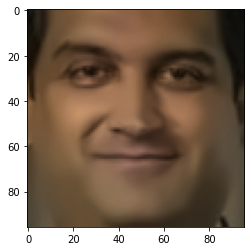

In [65]:
# Test Cell

print(UTK_dataset.shape)
img = UTK_dataset[0][0]
a = UTK_dataset[0][1]
print("Images Shape = ", img.shape)

print("Ages = ", a)

pyplot.imshow(np.array(img*255, dtype=int))
pyplot.show()

In [ ]:
# # Saving UTK dataset in a file
# np.save('UTK_dataset.npy', UTK_dataset)

In [ ]:
# # Loading UTK dataset from a file
# loaded_ds = np.load('UTK_dataset.npy', allow_pickle='TRUE')
# print(loaded_ds.shape)

# > **Merge the 2 Datasets ( Audience + UTK )**

In [ ]:
# Our Dataset
merged_dataset = np.array([]) # Audience + UTK
train_dataset = np.array([])
validation_dataset = np.array([])
test_dataset = np.array([])

# > **Train Test Split**

In [ ]:
# لسه مشوفتوش


# Fraction of the dataset to be used for testing.
TRAIN_TEST_SPLIT = 0.3

# Create train and test splits of the dataset.
num_examples_in_test_ds = int( dataset.cardinality().numpy() * TRAIN_TEST_SPLIT )

test_ds = dataset.take( num_examples_in_test_ds )
train_ds = dataset.skip( num_examples_in_test_ds )

print( 'Num examples in train ds {}'.format( train_ds.cardinality() ) )
print( 'Num examples in test ds {}'.format( test_ds.cardinality() ) )